In [1]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import time
import collections
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor, tensor
import pandas as pd
import openml

from optuna_kfoldCV import evaluate_dataset_with_model, run_all_openML_with_model
from regression_param_specs import evaluate_Ridge, evaluate_XGBoostRegressor

np.set_printoptions(precision=3, threshold=5) # Print options


from pathlib import Path

#from yourpackage import YourEstimator
from sklearn.linear_model import LogisticRegression
import tabmini
import pickle


import aeon  #E2E_MLP_ResNet

from models.random_feature_representation_boosting import GradientRFRBoostClassifier
from models.end2end import End2EndMLPResNet

/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
##############################################
#####      Equal/Random Guessing        ######
##############################################

from sklearn.base import BaseEstimator, ClassifierMixin

class EqualGuessing(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        return self

    def predict_proba(self, X):
        # Guess [0.5, 0.5]
        return np.ones((X.shape[0], 2)) * 0.5

    def decision_function(self, X):
        # Get the probabilities from predict_proba
        proba = self.predict_proba(X)
        # Calculate the log of ratios for binary classification
        decision = np.log((proba[:, 1] + 1e-10) / (proba[:, 0] + 1e-10))
        return decision
    



############# Gradient Random feature representation boosting
from sklearn.preprocessing import MinMaxScaler
from models.gridsearch_wrapper import SKLearnWrapper
from sklearn.model_selection import GridSearchCV, StratifiedKFold


class WrapperGridSearch(BaseEstimator, ClassifierMixin):
    def __init__(self, param_grid:Dict[str, List] , device="cpu"):
        self.device = device
        self.param_grid = param_grid

    def fit(self, X, y):
        # MinMaxScaler and convert to torch
        self.classes_ = np.unique(y)
        N, D = X.values.shape
        self.scaler = MinMaxScaler()
        X = self.scaler.fit_transform(X.values)
        X = torch.tensor(X).float()
        y = torch.tensor(y.values)[..., None].float()

        # Perform grid search with k-fold cross-validation
        estimator = SKLearnWrapper()
        grid_search = GridSearchCV(
            estimator=estimator,
            param_grid= {**self.param_grid, **{"seed": [42]}, **{"in_dim": [D]}, **{"n_classes": [2]}},
            cv=StratifiedKFold(n_splits=3),
            verbose=1,
        )
        grid_search.fit(X, y)

        # fit best model
        best_model = grid_search.best_estimator_
        print("Best params:", grid_search.best_params_)
        best_model.fit(X, y)
        best_model.set_model_eval()
        self.model = best_model
        return self


    def predict_proba(self, X):
        X = self.scaler.fit_transform(X.values)
        X = torch.tensor(X).to(self.device).float()
        proba_0 = torch.nn.functional.sigmoid(self.model.predict(X)).cpu().detach().numpy()
        return np.concatenate((1 - proba_0, proba_0), axis=1)


    def decision_function(self, X):
        # Get the probabilities from predict_proba
        proba = self.predict_proba(X)
        # Calculate the log of ratios for binary classification
        decision = np.log((proba[:, 1] + 1e-10) / (proba[:, 0] + 1e-10))
        return decision

In [3]:
from tabmini.estimators import get_available_methods

# Please note that includes and excludes are case-sensitive
get_available_methods()
#methods_to_consider = get_available_methods() - {'TabPFN'}

frozenset({'AutoGluon',
           'AutoPrognosis',
           'CatBoost',
           'HyperFast',
           'LightGBM',
           'TabPFN',
           'XGBoost'})

In [4]:
#####################################################
#####   Equal Guessing, and XGBoost baseline    #####
#####################################################

def test_on_PMLBmini(
        estimator: BaseEstimator,
        estimator_name: str, 
        dataset_save_path = 'save/PMLBmini_dataset.pkl',
        other_saved_methods = {}, #{'XGBoost'},
        ):
    
    #download dataset, cache it
    if not os.path.exists(dataset_save_path):
        dataset = tabmini.load_dataset(reduced=False)
        with open(dataset_save_path, 'wb') as f:
            pickle.dump(dataset, f)
    else:
        with open(dataset_save_path, 'rb') as f:
            dataset = pickle.load(f)

    # Perform the comparison
    train_results, test_results = tabmini.compare(
        estimator_name,
        estimator,
        dataset,
        working_directory=Path.cwd() / "results",
        scoring_method="roc_auc",
        methods= {},
        cv=3,
        time_limit=60,
        device="cpu",
        n_jobs=1,
    )
    return train_results, test_results

In [5]:
train1, test1 = test_on_PMLBmini(
    EqualGuessing(),
    'EqualGuessing',
    other_saved_methods={"XGBoost"},
    )

Evaluating EqualGuessing against {}...
Comparing EqualGuessing on analcatdata_aids
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing EqualGuessing
Comparing EqualGuessing on analcatdata_asbestos
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing EqualGuessing
Comparing EqualGuessing on analcatdata_bankruptcy
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods

In [6]:
train2, test2 = test_on_PMLBmini(
    WrapperGridSearch(param_grid = {
                'modelClass': [GradientRFRBoostClassifier],
                'l2_cls': [1, 0.1, 0.001, 0.0001],
                'n_layers': [0],
                'upscale_type': ["identity"],
                'use_batchnorm': [False],
                'lbfgs_max_iter': [300],
                'lbfgs_lr': [1.0],
                'activation': [nn.Tanh()],
            }),
    'Logistic (mine)',
    )

Evaluating Logistic (mine) against {}...
Comparing Logistic (mine) on analcatdata_aids
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing Logistic (mine)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'activation': Tanh(), 'in_dim': 4, 'l2_cls': 0.0001, 'lbfgs_lr': 1.0, 'lbfgs_max_iter': 300, 'modelClass': <class 'models.random_feature_representation_boosting.GradientRFRBoostClassifier'>, 'n_classes': 2, 'n_layers': 0, 'seed': 42, 'upscale_type': 'identity', 'use_batchnorm': False}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'activation': Tanh(), 'in_dim': 4, 'l2_cls': 0.0001, 'lbfgs_lr': 1.0, 'lbfgs_max_iter': 300, 'modelClass': <class 'models.random_feature_representatio

In [8]:
train3, test3 = test_on_PMLBmini(
    WrapperGridSearch(param_grid = {
                'modelClass': [GradientRFRBoostClassifier],
                'l2_cls': [1, 0.1, 0.001, 0.0001],
                'l2_ghat': [1.0],
                'n_layers': [1],
                'randfeat_xt_dim': [512],
                'randfeat_x0_dim': [0],
                'feature_type': ["SWIM"],
                'upscale_type': ["identity"],
                'use_batchnorm': [False],
                'lbfgs_max_iter': [300],
                'lbfgs_lr': [1.0],
                'SWIM_scale': [-0.75],
                'activation': [nn.Tanh()],
            }),
    'GRFRBoostID',
    other_saved_methods={},
    )

Evaluating GRFRBoostID against {}...
Comparing GRFRBoostID on analcatdata_aids
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing GRFRBoostID
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'SWIM_scale': -0.75, 'activation': Tanh(), 'feature_type': 'SWIM', 'in_dim': 4, 'l2_cls': 0.0001, 'l2_ghat': 1.0, 'lbfgs_lr': 1.0, 'lbfgs_max_iter': 300, 'modelClass': <class 'models.random_feature_representation_boosting.GradientRFRBoostClassifier'>, 'n_classes': 2, 'n_layers': 1, 'randfeat_x0_dim': 0, 'randfeat_xt_dim': 512, 'seed': 42, 'upscale_type': 'identity', 'use_batchnorm': False}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'SWIM_scale': -0.75, 'activation': Tanh(), 'feature_typ

In [43]:
# Random feature Neural Network

train4, test4 = test_on_PMLBmini(
    WrapperGridSearch(param_grid = {
                'modelClass': [GradientRFRBoostClassifier],
                'l2_cls': [1, 0.1, 0.001, 0.0001],
                'hidden_dim': [512],
                'n_layers': [0],
                'upscale_type': ["iid"],
                'use_batchnorm': [False],
                'lbfgs_max_iter': [300],
                'lbfgs_lr': [1.0],
                'activation': [nn.Tanh()],
            }),
    'RFNN',
    other_saved_methods={},
    )

Evaluating GRFRBoost (mine) against {}...
Comparing GRFRBoost (mine) on analcatdata_aids
estimated name is not in methods: AutoGluon
estimated name is not in methods: AutoPrognosis
estimated name is not in methods: TabPFN
estimated name is not in methods: HyperFast
estimated name is not in methods: LightGBM
estimated name is not in methods: XGBoost
estimated name is not in methods: CatBoost
Testing GRFRBoost (mine)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params: {'activation': Tanh(), 'hidden_dim': 512, 'in_dim': 4, 'l2_cls': 10, 'lbfgs_lr': 1.0, 'lbfgs_max_iter': 300, 'modelClass': <class 'models.random_feature_representation_boosting.GradientRFRBoostClassifier'>, 'n_classes': 2, 'n_layers': 0, 'seed': 42, 'upscale_type': 'iid', 'use_batchnorm': False}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params: {'activation': Tanh(), 'hidden_dim': 512, 'in_dim': 4, 'l2_cls': 10, 'lbfgs_lr': 1.0, 'lbfgs_max_iter': 300, 'modelClass': <class 'models.

In [ ]:
train5, test5 = test_on_PMLBmini(
    WrapperGridSearch(param_grid = {
                'modelClass': [GradientRFRBoostClassifier],
                'l2_cls': [1, 0.1, 0.001, 0.0001],
                'l2_ghat': [1.0],
                'hidden_dim': [512],
                'n_layers': [1],
                'randfeat_xt_dim': [512],
                'randfeat_x0_dim': [0],
                'feature_type': ["SWIM"],
                'upscale_type': ["iid"],
                'use_batchnorm': [False],
                'lbfgs_max_iter': [300],
                'lbfgs_lr': [1.0],
                'SWIM_scale': [-0.75],
                'activation': [nn.Tanh()],
            }),
    'GRFRBoost',
    other_saved_methods={},
    )

In [9]:
# Load the CSV and set the index
saved_results = pd.read_csv('scripts/TabMini/plotting/results/test_scores_wide_3600.csv', delimiter=";")
saved_results.set_index("PMLB dataset", inplace=True)
saved_results.index.name = None

In [12]:
combined_results = saved_results.copy()
for df in [test1, test3]: # test4, test5]:
    combined_results = combined_results.join(df, how='inner')
combined_results

,AutoPrognosis,AutoGluon,TabPFN,Logistic regression,HyperFast,EqualGuessing,GRFRBoostID
parity5,0.27,1.00,0.02,0.17,0.02,0.5,0.704959
analcatdata_fraud,0.86,0.80,0.79,0.77,0.73,0.5,0.904691
analcatdata_aids,0.73,0.77,0.63,0.61,0.53,0.5,0.842849
analcatdata_bankruptcy,0.98,0.98,0.96,0.97,0.88,0.5,0.984790
analcatdata_japansolvent,0.85,0.88,0.91,0.85,0.91,0.5,0.975899
labor,0.88,0.94,0.99,0.97,0.98,0.5,0.995897
analcatdata_asbestos,0.87,0.84,0.85,0.86,0.87,0.5,0.897851
lupus,0.84,0.79,0.82,0.85,0.79,0.5,0.863056
postoperative_patient_data,0.49,0.55,0.44,0.38,0.34,0.5,0.704509
analcatdata_cyyoung9302,0.89,0.85,0.87,0.87,0.84,0.5,0.930076


In [12]:
# import pickle

# dataset
# with open('save/PMLBmini_dataset.pkl', 'wb') as f:
#     pickle.dump(dataset, f)

/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:600: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  return result_to_tuple(hypotest_fun_out(*samples, **kwds))


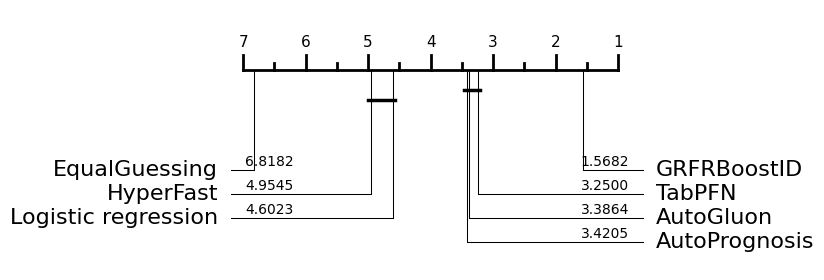

In [13]:
def auc_df_to_aeonresults(auc_df):
    return (auc_df.values, auc_df.columns.tolist())

from aeon.visualisation import plot_critical_difference, plot_significance


results = auc_df_to_aeonresults(combined_results)
plot = plot_critical_difference(results[0], results[1], alpha=0.05, lower_better=False)

/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:600: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  return result_to_tuple(hypotest_fun_out(*samples, **kwds))


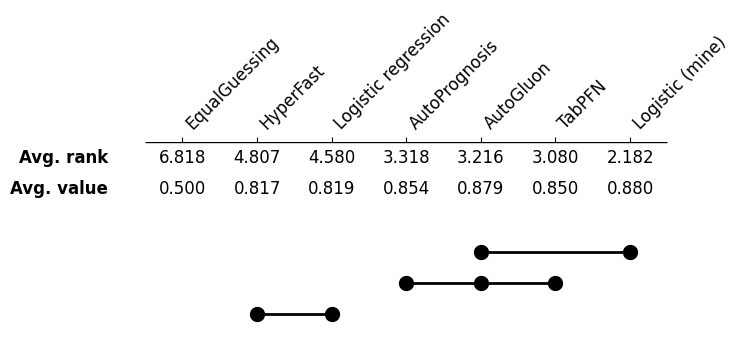

In [42]:
plot = plot_significance(results[0], results[1], alpha=0.05, lower_better=False)